# Magic: the Gathering - some ML stuff

Our aim here is to 
1. Analyze how the MTG cards look like
2. Use neural networks to generate random MTG cards - both the textual parts and (hopefully the images)

**Under construction**

The data we use was downloaded from [scryfall](https://scryfall.com/docs/api/bulk-data), and then we used some non-cloud python to wrangle the ~1Gb .json file to something more manageable. We did this by essentially dropping first all non-english cards and then removing more than half of the card data provided by the original data set. The fields we kept were

- "object"
- "id"
- "name"
- "lang"
- "mana_cost"
- "cmc"
- "type_line"
- "oracle_text"
- "power"
- "toughness"
- "colors"
- "color_identity"
- "set"
- "set_name"
- "set_type"
- "rarity"
- "flavor_text"

Later on when we want to generate not just the texts but also images, we will rewrangle a bit to get image link data. The "id"-field is kept in all wrangling to serve as a unique identifier.

## Importing data and packages

We first import the standard libraries to do pretty much anything

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

The following cell contains the IBM Watson notebook autogenerated code to read Formatted_list.json into a json object named 'card_rext_json' and then creates a pandas DataFrame object called 'cards_df' from it. It will be hidden in the github version; you should uncomment the code in the block after it if you need to use this outside the notebook.

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# Uncomment the following line if you are applying this code outside the original notebook.
# cards_df = pd.read_json("Formatted_list.json").sort_index()

all_cards_amount = cards_df.shape[0]
print(cards_df.shape)
cards_df.head()

(50454, 17)


,object,id,name,lang,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,set,set_name,set_type,rarity,flavor_text
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,en,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],tsp,Time Spiral,expansion,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,en,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,Zendikar,expansion,common,"""We take only what we need to survive. Believe..."
2,card,0000a54c-a511-4925-92dc-01b937f9afad,Spirit,en,,0.0,Token Creature — Spirit,Flying,1,1,[W],[W],tmm2,Modern Masters 2015 Tokens,token,common,None
3,card,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,en,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],xln,Ixalan,expansion,common,None
4,card,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,en,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,None,None,[G],[G],3ed,Revised Edition,core,rare,None


Above we seed a snippet of the type of data we are working with at the moment.

## Data Wrangling and pruning

We'll now start to massage the data set to a more applicable form. Some of our aims are:
1. Remove superfluous columns
2. Remove duplicates.
3. Turn type_line into two columns that contain the card type (creature, enchantment, etc) and then the possible creature type which will be set to None for non-creatures.
4. Create dictionaries for the categorical variables of
    * mana_cost
    * cmc 
    * type_line = (card_type, creature_type?)
    * power
    * toughness
    * colors
    * color_identity
    * set
    * set_type
    * rarity
5. Create functions to go from text to integer array representation (and back) for the text fields of
    * name
    * oracle_text
    * flavor_text
    * card_type
  
In the end the dictionaries of parts 4 and 5 are saved, along with the wrangled (and mangled) data set into .json files for safekeeping.

### Data Pruning

In [4]:
# Dropping columns that we will not need
# We sort the list by oracle text and flavor text to make sure that when we remove duplicates we prefer to remove a non-textual version.
columns_pruned_df = cards_df.drop(['object', 'lang', 'set_name', 'set_type'], axis = 1).sort_values(by=['oracle_text', 'flavor_text'], ascending=False)

# Removing some bios(?) that are identified by type_line equaling 'Card'
bios_pruned_df  = columns_pruned_df.drop(columns_pruned_df[columns_pruned_df.type_line == 'Card'].index)

# Finally we drop duplicates
cards_pruned_df = bios_pruned_df.drop_duplicates(subset = ['name']).sort_index()

cards_pruned_df.head()

,id,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],tsp,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,common,"""We take only what we need to survive. Believe..."
3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],xln,common,None
4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,None,None,[G],[G],3ed,rare,None
5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,Creature — Human Knight,"When Venerable Knight dies, put a +1/+1 counte...",2,1,[W],[W],eld,uncommon,"""May this blade guide you on your great journe..."


We next process the type_line column into two new columns.

In [5]:
# Running this cell takes some time.

# In the type_line the parts are separated by the following symbol.
type_separator = '—'

# We define a function to parse rows one by one
def type_line_parser(row):
    type_string = row.type_line
    
    # We divide the parsing in two parts depending on if we see the separating symbol.
    if type_separator in type_string: 
        # For creature names we split the type_line on the first instance and then 
        # strip the string from leading or following spaces etc
        card_type, creature_name = [s.strip() for s in type_string.split(type_separator,1)]
        
    else:
        # For non-creature things we just remove leading and following spaces
        # and set the creature type to None.
        card_type = type_string.strip()
        creature_name = None
    
    row['type'] = card_type
    row['creature_type'] = creature_name
    
    return(row)

# Finally we save the new dataframe and drop the old column.
typed_cards_df = cards_pruned_df.apply(type_line_parser, axis = 1).drop(['type_line'], axis=1)

In [6]:
# We take a peek at what the data looks after first round of pruning.

typed_cards_df.head()


,id,name,mana_cost,cmc,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text,type,creature_type
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,All Sliver creatures have double strike.,3,3,[R],[R],tsp,uncommon,"""A rift opened, and our arrows were abruptly s...",Creature,Sliver
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,common,"""We take only what we need to survive. Believe...",Creature,Kor Soldier
3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,{2}{U},3.0,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],xln,common,None,Creature,Siren Pirate
4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,{G},1.0,Enchant creature (Target a creature as you cas...,None,None,[G],[G],3ed,rare,None,Enchantment,Aura
5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,"When Venerable Knight dies, put a +1/+1 counte...",2,1,[W],[W],eld,uncommon,"""May this blade guide you on your great journe...",Creature,Human Knight


In [7]:
# We find those cards that have a non-empty flavor text.
flavor_text_cards = cards_pruned_df.loc[cards_pruned_df.flavor_text.notna()]
flavor_text_cards_amount = flavor_text_cards.shape[0]
print(flavor_text_cards.shape)
flavor_text_cards.head()

(13544, 13)


,id,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],tsp,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,common,"""We take only what we need to survive. Believe..."
5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,Creature — Human Knight,"When Venerable Knight dies, put a +1/+1 counte...",2,1,[W],[W],eld,uncommon,"""May this blade guide you on your great journe..."
6,00020b05-ecb9-4603-8cc1-8cfa7a14befc,Wildcall,{X}{G}{G},2.0,Sorcery,"Manifest the top card of your library, then pu...",None,None,[G],[G],ugin,rare,A howl on the wind hides many dangers.
9,00042443-4d4e-4087-b4e5-5e781e7cc5fa,Wall of Vipers,{2}{B},3.0,Creature — Snake Wall,Defender (This creature can't attack.)\n{3}: D...,2,4,[B],[B],pcy,uncommon,"What wall can never be climbed, but is always ..."


In [8]:
# We find those cards that have a non-empty oracle text
oracle_text_cards = cards_pruned_df.loc[cards_pruned_df.oracle_text.notna()]
oracle_cards_amount = oracle_text_cards.shape[0]
print(oracle_text_cards.shape)
oracle_text_cards.head()

(20742, 13)


,id,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],tsp,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,common,"""We take only what we need to survive. Believe..."
3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],xln,common,None
4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,None,None,[G],[G],3ed,rare,None
5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,Creature — Human Knight,"When Venerable Knight dies, put a +1/+1 counte...",2,1,[W],[W],eld,uncommon,"""May this blade guide you on your great journe..."


Let's plot the mana cost distributions of common, uncommon, rare and mythic cards compared to the mana costs of all cards.

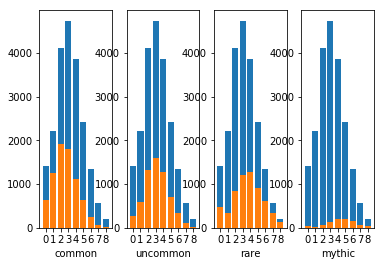

In [9]:
mana_cost_amounts = typed_cards_df.cmc.value_counts()


j = 1
for type_string in ['common', 'uncommon', 'rare', 'mythic']:
    plt.subplot(1,4,j)
    j= j+1
    x = range(9)
    y = [mana_cost_amounts[j] for j in x]
    plt.xticks(range(9))
    plt.bar(x,y)
    plt.xlabel(type_string)
    mana_cost_amounts2 = typed_cards_df.loc[typed_cards_df.rarity==type_string].cmc.value_counts()
    
    x = range(9)
    y = [mana_cost_amounts2[j] for j in x]
    plt.xticks(range(9))
    plt.bar(x,y)

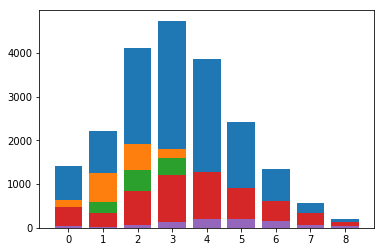

In [10]:
mana_cost_amounts = typed_cards_df.cmc.value_counts()
x = range(9)
y = [mana_cost_amounts[j] for j in x]
plt.xticks(range(9))
plt.bar(x,y)

for type_string in ['common', 'uncommon', 'rare', 'mythic']:

    mana_cost_amounts2 = typed_cards_df.loc[typed_cards_df.rarity==type_string].cmc.value_counts()
    
    x = range(9)
    y = [mana_cost_amounts2[j] for j in x]
    plt.xticks(range(9))
    plt.bar(x,y)

## Dictionary creation

Next we wish to turn the categorical variables to integer representations and then the string variables to integer representations of the strings. (These will more easily yield one-hot encodings later on.)

### Dictionaries - categorical variables


We'll be creating lists and dictionaries for each of the categorical columns listed below to make the inputs to the NN more reasonable. Our first task is to alter the data in columns 'colors' and 'color_identity' to a string format as it is currently in a list.

In [11]:
df = typed_cards_df.copy() # We create a copy of the dataframe to make sure we don't actually mangle something here

df = df.reset_index() #  After pruning the index is out of whack.

# The data in color columns is in list form, and we need to turn it into some kinds of (unique) strings.
def array_to_string(row):
    array = row['color_identity']
    string = ''.join(array)
    row['color_identity'] = string

    try:
        array = row['colors']
        string = ''.join(array)
        row['colors'] = string    
    except:
        row['colors'] = None 
    
    return row

df = df.apply(array_to_string, axis= 1)

categorical_columns = ['mana_cost', 
                       'cmc', 
                       'power', 
                       'toughness',
                       'colors',
                       'color_identity', 
                       'set', 
                       'rarity', 
                       'type'
                      ]

df[categorical_columns].dtypes
df.head()

,index,id,name,mana_cost,cmc,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text,type,creature_type
0,0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,All Sliver creatures have double strike.,3,3,R,R,tsp,uncommon,"""A rift opened, and our arrows were abruptly s...",Creature,Sliver
1,1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,"When Kor Outfitter enters the battlefield, you...",2,2,W,W,zen,common,"""We take only what we need to survive. Believe...",Creature,Kor Soldier
2,3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,{2}{U},3.0,Flying\nWhen Siren Lookout enters the battlefi...,1,2,U,U,xln,common,None,Creature,Siren Pirate
3,4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,{G},1.0,Enchant creature (Target a creature as you cas...,None,None,G,G,3ed,rare,None,Enchantment,Aura
4,5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,"When Venerable Knight dies, put a +1/+1 counte...",2,1,W,W,eld,uncommon,"""May this blade guide you on your great journe...",Creature,Human Knight


In [12]:
df.head()

,index,id,name,mana_cost,cmc,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text,type,creature_type
0,0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,All Sliver creatures have double strike.,3,3,R,R,tsp,uncommon,"""A rift opened, and our arrows were abruptly s...",Creature,Sliver
1,1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,"When Kor Outfitter enters the battlefield, you...",2,2,W,W,zen,common,"""We take only what we need to survive. Believe...",Creature,Kor Soldier
2,3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,{2}{U},3.0,Flying\nWhen Siren Lookout enters the battlefi...,1,2,U,U,xln,common,None,Creature,Siren Pirate
3,4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,{G},1.0,Enchant creature (Target a creature as you cas...,None,None,G,G,3ed,rare,None,Enchantment,Aura
4,5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,"When Venerable Knight dies, put a +1/+1 counte...",2,1,W,W,eld,uncommon,"""May this blade guide you on your great journe...",Creature,Human Knight


In [13]:
print(df.shape)
print(len(df.mana_cost.unique()))
#df.mana_cost.value_counts()


(21019, 15)
806


In [14]:
mana_cost2int = {cost : idx for idx, cost in enumerate(df.mana_cost.unique())}

int2mana_cost = np.array(df.mana_cost.unique())


In [15]:
mana_cost2int['{HW}']
int2mana_cost[695]

'{HW}'

In [16]:
category_translators = {}

for categorizable in categorical_columns:
    print("Creating dicts for: {:15}".format(categorizable), end='\t')
    cat2int = {category : idx for idx, category in enumerate(df[categorizable].unique())}
    int2cat = np.array(df[categorizable].unique())
    
    category_translators[categorizable] = [cat2int, int2cat]
    
    print("Success!")

Creating dicts for: mana_cost      	Success!
Creating dicts for: cmc            	Success!
Creating dicts for: power          	Success!
Creating dicts for: toughness      	Success!
Creating dicts for: colors         	Success!
Creating dicts for: color_identity 	Success!
Creating dicts for: set            	Success!
Creating dicts for: rarity         	Success!
Creating dicts for: type           	Success!


In [17]:
# Testing dictionaries

TEST_AMOUNT = 1000
test_flag = True

for categorizable in categorical_columns:
    maximum = len(df[categorizable])
    
    cat2int, int2cat = category_translators[categorizable]
    for j in np.random.randint(maximum, size=TEST_AMOUNT):
        original = df[categorizable][j]
        translated = cat2int[original]
        double_translated = int2cat[translated]
        #print(original, "->",translated , "->", double_translated )
        
        if double_translated == original:
            #print("Success!: ", original, "->",translated , "->", double_translated )
            continue
        else:
            test_flag = False
            print("FAIL!: ", original, "->",translated , "->", double_translated )
        
if test_flag:
    print("Tests passed successfully!")
        

Tests passed successfully!


In [18]:

def category_translation_cat2idx(row):
    
    for categorizable in categorical_columns:
        cat2int, int2cat = category_translators[categorizable]
        row[categorizable] = cat2int[row[categorizable]]
    return row


df_indexed = df.apply(category_translation_cat2idx, axis = 1).set_index('id').drop('index', axis = 1)


In [19]:
df_indexed.head()

,name,mana_cost,cmc,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text,type,creature_type
id,,,,,,,,,,,,,
0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,0,0,All Sliver creatures have double strike.,0,0,0,0,0,0,"""A rift opened, and our arrows were abruptly s...",0,Sliver
00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,1,1,"When Kor Outfitter enters the battlefield, you...",1,1,1,1,1,1,"""We take only what we need to survive. Believe...",0,Kor Soldier
0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,2,2,Flying\nWhen Siren Lookout enters the battlefi...,2,1,2,2,2,1,None,0,Siren Pirate
00012bd8-ed68-4978-a22d-f450c8a6e048,Web,3,3,Enchant creature (Target a creature as you cas...,3,2,3,3,3,2,None,1,Aura
0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,4,3,"When Venerable Knight dies, put a +1/+1 counte...",1,3,1,1,4,0,"""May this blade guide you on your great journe...",0,Human Knight


In [20]:
# We save bot the categorized data and the dictionaries
# (This part might not work in a Jupyter notebook depending on your setup. It is not required if you've run through all the previous parts.)
INDEXED_DF_FILENAME = "categorized_cards.json"
DICTIONARIES_FILENAME = "dictionaries.json"

df_indexed.to_json(INDEXED_DF_FILENAME)
pd.DataFrame(category_translators).to_json(DICTIONARIES_FILENAME)


## RNN for text comprehension

In this section we use the categorized and wrangled data to teach a RNN what the different text fields look like.
